In [5]:
import nbsetup

from simulations.daisy_world.model import DaisyWorld, POP_DEFAULT

In [2]:
# Netlogo sim http://www.netlogoweb.org/launch#http://ccl.northwestern.edu/netlogo/models/models/Sample%20Models/Biology/Daisyworld.nlogo
# Calcs http://gingerbooth.com/flash/daisyball/daisyworldmath.html
# 

CPU times: user 4.65 s, sys: 24.8 ms, total: 4.68 s
Wall time: 4.68 s


,entropy,temperature,luminosity,empty,white,black
0,1.522748,16.915030,1.0,341,169,331
1,1.433880,26.899112,1.0,159,219,463
2,1.260795,31.265053,1.0,63,285,493
3,1.095682,31.265590,1.0,18,324,499
4,0.993761,29.857737,1.0,2,337,502
...,...,...,...,...,...,...
495,1.162077,22.675771,1.0,25,391,425
496,1.115632,22.394525,1.0,16,395,430
497,1.097998,22.146060,1.0,13,394,434
498,1.072888,22.106783,1.0,9,395,437


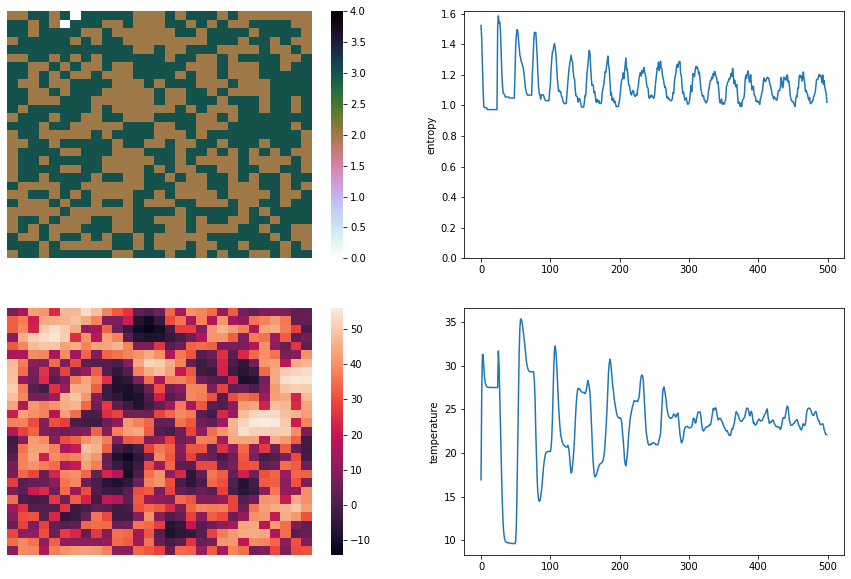

In [6]:
%%time
model = DaisyWorld(POP_DEFAULT)
model.simulate(500)
model.plot()
model.df

In [7]:
model.df[-10:].mean()

entropy          1.132652
temperature     22.763934
luminosity       1.000000
empty           20.300000
white          387.500000
black          433.200000
dtype: float64